In [58]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from functools import reduce
# import statsmodels.stats.diagnostic.acorr_ljungbox
import statsmodels as stats
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.graphics.tsaplots import plot_acf

labour_csv = pd.read_csv('LabourProductivity.csv')
# labour_csv

# !python3 -m pip install statsmodels
# !pip install statsmodels

In [35]:
# econ_csv   = pd.read_csv('EconomicSentiment.csv')
# econ_csv

gdp_csv = pd.read_csv('gdp_from_1975.csv')
# gdp_csv

In [36]:
incomeineq_csv = pd.read_csv('incomeinequality_reformatted.csv')
# incomeineq_csv

In [37]:
STRONG_CORR_THRESHOLD = 0.7
def within_threshold(x, t):
    return x >= t or x <= -t

def c_data(country_name):
    return labour_csv[labour_csv['Country Name'] == country_name].iloc[0][2:].astype(float)

def calc_autocorr(country_name, lag=1):
    return c_data(country_name).autocorr(lag=lag)

lags   = list(range(2, 10))
acorrs = [ calc_autocorr('United Kingdom', l) for l in lags ]
# print(acorrs)

# print(c_data('United Kingdom'))

# fig = plt.plot(lags, acorrs)
# plt.suptitle('Lag vs Correlation for Norway')
# plt.xlabel('Lag')
# plt.ylabel('Correlation')

default_lag = 1

def calc_autocorr_all(data, lag=default_lag):
    return data.apply(lambda row: row[2:].astype(float).autocorr(lag=lag), axis='columns')

def calc_labour_autocorr(lag):
    labour_autocorr     = pd.DataFrame(calc_autocorr_all(labour_csv, lag=lag), columns=['Labour Productivity Autocorrelation'])
    labour_autocorr.insert(0, 'Country Code', labour_csv['Country Code'])
    return labour_autocorr
labour_autocorr = calc_labour_autocorr(lag=default_lag)

# econ_autocorr       = pd.DataFrame(calc_autocorr_all(econ_csv), columns=['Economic Sentiment Autocorrelation'])
# econ_autocorr.insert(0, 'Country Code', econ_csv['Country Code'])
def calc_gdp_autocorr(lag):
    gdp_autocorr        = pd.DataFrame(calc_autocorr_all(gdp_csv, lag=lag), columns=['GDP Autocorrelation'])
    gdp_autocorr.insert(0, 'Country Code', gdp_csv['Country Code'])
    return gdp_autocorr
gdp_autocorr = calc_gdp_autocorr(lag=default_lag)
    
def calc_incomeineq_autocorr(lag):
    incomeineq_autocorr = pd.DataFrame(calc_autocorr_all(incomeineq_csv, lag=lag), columns=['Income Inequality Autocorrelation'])
    incomeineq_autocorr.insert(0, 'Country Code', incomeineq_csv['Country Code'])
    return incomeineq_autocorr
incomeineq_autocorr = calc_incomeineq_autocorr(lag=default_lag)

# labour_autocorr
# econ_autocorr
# merged

In [38]:
def calc_merged(labour_autocorr, gdp_autocorr, incomeineq_autocorr):    
    merged = pd.merge(left=labour_autocorr, right=gdp_autocorr, left_on='Country Code', right_on='Country Code')
    merged = pd.merge(left=merged, right=incomeineq_autocorr, left_on='Country Code', right_on='Country Code')
    return merged

def calc_merged_lag(lag):
    labour_autocorr     = calc_labour_autocorr(lag)
    gdp_autocorr        = calc_gdp_autocorr(lag)
    incomeineq_autocorr = calc_incomeineq_autocorr(lag)
    return calc_merged(labour_autocorr, gdp_autocorr, incomeineq_autocorr)

def calc_merged_multi(lags):
    merged = pd.DataFrame()
    
    labour_lags     = calc_labour_autocorr(lags[0])
    gdp_lags        = calc_gdp_autocorr(lags[0])
    incomeineq_lags = calc_incomeineq_autocorr(lags[0])
    
    for data, calc_f, label in [(labour_lags,     calc_labour_autocorr,     'Labour Productivity Autocorrelation'),
                                (gdp_lags,        calc_gdp_autocorr,        'GDP Autocorrelation'),
                                (incomeineq_lags, calc_incomeineq_autocorr, 'Income Inequality Autocorrelation')]:
        for l in lags[1:]:
            z                    = calc_f(l)
            data[f'{label} {l}'] = z[label]
        stats_ = data.apply(lambda x: len([ xx for xx in x if within_threshold(xx, STRONG_CORR_THRESHOLD) ] if x.name != "Country Code" else ''), axis=0, result_type='reduce')
#         print(stats)
#         data = data.append(stats, ignore_index=True)
        data.loc['Stats'] = stats_
        
        labels = [('', 'Country Code')] + [ (label, f'Lag {l}') for l in lags ]
        data.columns = pd.MultiIndex.from_tuples( tuple(labels) )

    
#         stats = data.apply(lambda x: len([ xx for xx in x if within_threshold(xx, STRONG_CORR_THRESHOLD) ] if x.name != "_x" else ''), axis=0, result_type='reduce')
#         stats = data.apply(lambda x: x if x.name != "_x" else '', axis=0, result_type='reduce')
    #     stats['Country Code'] = '# Countries Within Threshold'
    
    # this is so messy
    
    merged = labour_lags
    merged = pd.merge(left=merged, right=gdp_lags, left_on=merged['']['Country Code'], right_on=gdp_lags['']['Country Code'])
    
    merged = merged.drop('key_0', axis=1)
    
    merged = pd.merge(left=merged, right=incomeineq_lags, left_on=merged['_x']['Country Code'], right_on=incomeineq_lags['']['Country Code'])
    
    merged = merged.drop('_y', axis=1)
    merged = merged.drop('', axis=1)
    merged = merged.drop('key_0', axis=1)
    
    return merged        

merged = calc_merged(labour_autocorr, gdp_autocorr, incomeineq_autocorr)
# merged

multim = calc_merged_multi([1, 2, 3])
multim

/home/adam/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



_x Labour Productivity Autocorrelation                        \
   Country Code                               Lag 1      Lag 2      Lag 3   
0           AUT                            0.756414   0.513981   0.373920   
1           BEL                            0.482716  -0.028158  -0.409866   
2           BGR                            0.976329   0.971854   0.962031   
3           CHE                            0.692498   0.102782  -0.272142   
4           CYP                            0.910665   0.733632   0.561454   
5           CZE                            0.890026   0.691392   0.446937   
6           DEU                            0.670293   0.307743   0.101392   
7           DNK                            0.856207   0.721130   0.576021   
8           ESP                            0.314582  -0.118712   0.108771   
9           EST                            0.911567   0.832620   0.825945   
10          FIN                            0.883792   0.732228   0.655377   
11          FRA                            0.798160   0.651524   0.584933   
12          GBR                            0.958998   0.948042   0.873370   
13          GRC                            0.954632   0.895021   0.831573   
14          HRV                            0.662465   0.116810   0.071831   
15          HUN                            0.761571   0.395089  -0.151136   
16          IRL                            0.875385   0.780880   0.700472   
17          ISL                            0.466883  -0.181265  -0.443899   
18          ITA                            0.971029   0.927739   0.881028   
19          LTU                            0.923558   0.834205   0.784287   
20          LUX                            0.617692   0.063432  -0.434639   
21          LVA                            0.978372   0.965543   0.961814   
22          MKD                            0.385586   0.371659  -0.147962   
23          MLT                            0.277277  -0.200805  -0.458627   
24          NLD                            0.938924   0.853752   0.763853   
25          NOR                            0.790845   0.607768   0.394122   
26          POL                            0.964460   0.887533   0.791747   
27          PRT                            0.354543  -0.289345  -0.056281   
28          ROU                            0.973335   0.913561   0.822865   
29          SVK                            0.803360   0.443763  -0.052390   
30          SVN                            0.653418   0.313862   0.080677   
31          SWE                            0.878684   0.738832   0.743971   
32            0                           21.000000  15.000000  12.000000   

   GDP Autocorrelation                        \
                 Lag 1      Lag 2      Lag 3   
0             0.992916   0.988406   0.987116   
1             0.993343   0.990495   0.988965   
2             0.991607   0.982830   0.974641   
3             0.994718   0.987371   0.981857   
4             0.988008   0.957839   0.916928   
5             0.987535   0.972913   0.953600   
6             0.998257   0.996232   0.994039   
7             0.998984   0.998163   0.996998   
8             0.990962   0.969426   0.935630   
9             0.990091   0.975155   0.965121   
10            0.993016   0.979869   0.968966   
11            0.999326   0.998503   0.998000   
12            0.988589   0.972983   0.960673   
13            0.971015   0.898002   0.762112   
14            0.987785   0.960764   0.921525   
15            0.982024   0.964793   0.943000   
16            0.983929   0.954718   0.906909   
17            0.935764   0.831576   0.690482   
18            0.992202   0.980227   0.970643   
19            0.988822   0.974450   0.967105   
20            0.996810   0.993129   0.992426   
21            0.974094   0.926751   0.896916   
22            0.996044   0.991295   0.985111   
23            0.992072   0.988176   0.980866   
24            0.994553   0.983475   0.971016   
25            0.98922

In [39]:
# fig = px.scatter(merged, x='Labour Productivity Autocorrelation', y='Economic Sentiment Autocorrelation', title='Comparison of Autocorrelations Between Datasets', color = "Country Code")
# fig = px.scatter(merged, x='Labour Productivity Autocorrelation', y='Income Inequality Autocorrelation', title='Comparison of Autocorrelations Between Datasets', color = "Country Code")
fig = px.scatter_3d(merged, x='Labour Productivity Autocorrelation',
                            y='Income Inequality Autocorrelation',
                            z="GDP Autocorrelation",
                            title='Comparison of Autocorrelations Between Datasets',
                            color = "Country Code",
                            color_continuous_scale='Inferno')
fig.update_layout()
# fig.update_layout(xaxis_range=[-1,1])
# fig.update_layout(yaxis_range=[-1,1])
fig.update_layout(
    scene = {
    "xaxis": { "range": [-1, 1] },
    "yaxis": { "range": [-1 ,1] },
    "zaxis": { "range": [-1, 1] },
    "aspectmode": "cube"},
    margin = dict(l=0, r=0, b=0, t=0),
#     legend = {'orientation': 'h'},
    showlegend=False)
# fig.update_layout(zaxis_range=[-1,1])

fig.update_layout(title_text=(f'Autocorrelation of Labour Productivity'
                               '<br> vs Autocorrelation of GDP'
                               '<br> vs Autocorrelation of Income Inequality'
                              f'<br> (per Country, Lag = {default_lag})'),
                 title_x=0.5,
                 title_y=0.9,
                 font = { 'size': 10 })


# fig.update_layout(
#     margin=dict(l=0, r=50, t=0, b=50)
# )

fig.show()

In [40]:
def scatter_2d_data(x, y, lag=default_lag):
    str_x = x[:x.find(' Autocorrelation')]
    str_y = y[:y.find(' Autocorrelation')]
    fig = px.scatter(merged, x=x, y=y,
                     title=f'Autocorrelation of {str_x} vs Autocorrelation of <br>{str_y} (per Country), Lag = {lag}')
    fig.update_xaxes(range=[-1, 1])
    fig.update_yaxes(range=[-1, 1])
    fig.update_layout(title_x=0.5)
    fig.show()

def scatter_2d_data_lags(x, y, lags):
    str_x = x[:x.find(' Autocorrelation')]
    str_y = y[:y.find(' Autocorrelation')]
    
    # for diff lags
    mergeds = [ (l, calc_merged_lag(l)) for l in lags ]
    
    fig = go.Figure()
#     print(px.colors.sequential.Agsunset)
    for l, m in mergeds:
        opacity_level = (max(lags) - l + 1) / (max(lags))
#         opacity_level = opacity_level / 2 + 0.5
#         opacity_level = (max(lags) - l) / (max(lags))
#         if l == 1: opacity_level = 1
#         print(opacity_level)
        fig.add_trace(go.Scatter(x=m[x],
                                 y=m[y],
                                 mode='markers',
                                 name=f'Lag = {l}',
                                 opacity=opacity_level,
#                                  marker={ 'color': (px.colors.sequential.Sunsetdark[l]) }
                                 marker={ 'color': (px.colors.sequential.Aggrnyl[l]) },
#                                  line=dict(width=2, color='DarkSlateGrey')
                                 )
                     )
        if l == 1:
            fig.update_traces(marker=dict(size=9,
                          line=dict(width=2,
                                        color='Blue')),
                  selector=dict(mode='markers'))
    
    fig.update_xaxes(range=[-1, 1])
    fig.update_yaxes(range=[-1, 1])
    fig.update_layout(title_x=0.5,
                     title_text=f'Autocorrelation of {str_x} vs Autocorrelation of <br>{str_y} (per Country) for Different Lag Values')
    fig.update_xaxes(title_text=x)
    fig.update_yaxes(title_text=y)
    fig.show()
    
# scatter_2d_data('Labour Productivity Autocorrelation', 'Income Inequality Autocorrelation')
# scatter_2d_data('GDP Autocorrelation', 'Income Inequality Autocorrelation')
# scatter_2d_data('Labour Productivity Autocorrelation', 'GDP Autocorrelation')

target_lags = range(1, 6)

scatter_2d_data_lags('Labour Productivity Autocorrelation', 'Income Inequality Autocorrelation', lags=target_lags)
scatter_2d_data_lags('GDP Autocorrelation', 'Income Inequality Autocorrelation', lags=target_lags)
scatter_2d_data_lags('Labour Productivity Autocorrelation', 'GDP Autocorrelation', lags=target_lags)

In [41]:
def threshold_data(data, column): 
    return data [(data[column] > STRONG_CORR_THRESHOLD) | (data[column] < -STRONG_CORR_THRESHOLD)]

def latex_table(data):
    tt = data.transpose()
#     print(tt)
#     stats = data.apply(lambda x: len([ xx for xx in x if within_threshold(xx, STRONG_CORR_THRESHOLD) ] if x.name != "Country Code" else ''), axis=0, result_type='reduce')
#     stats = data.apply(lambda x: len([ xx for xx in x if within_threshold(xx, STRONG_CORR_THRESHOLD) ] if x.name != "_x" else ''), axis=0, result_type='reduce')
#     stats = data.apply(lambda x: x if x.name != "_x" else '', axis=0, result_type='reduce')
#     stats['Country Code'] = '# Countries Within Threshold'
    
#     data = data.append(stats, ignore_index=True)
    
    f = lambda s: '{:.2f}'.format(s) if within_threshold(float(s), STRONG_CORR_THRESHOLD) else '{\\textcolor{lightgray}{' + '{:.2f}'.format(s) + '}}'
    g = lambda s: s
    return data.to_latex(index=False, column_format='c|ccccccccc', float_format="%.2f", formatters=[g, f, f, f, f, f, f, f, f, f], escape=False)
#     return data.to_latex(index=False, column_format='c|ccc', float_format="%.2f")

# labour_autocorr = threshold_data(labour_autocorr, 'Labour Productivity Autocorrelation')
# labour_autocorr

# print(latex_table(labour_autocorr))

print(latex_table(multim))

\begin{tabular}{c|ccccccccc}
\toprule
          _x & \multicolumn{3}{l}{Labour Productivity Autocorrelation} & \multicolumn{3}{l}{GDP Autocorrelation} & \multicolumn{3}{l}{Income Inequality Autocorrelation} \\
Country Code &                               Lag 1 &                          Lag 2 &                          Lag 3 &               Lag 1 & Lag 2 &                         Lag 3 &                             Lag 1 &                          Lag 2 &                          Lag 3 \\
\midrule
         AUT &                                0.76 &  {\textcolor{lightgray}{0.51}} &  {\textcolor{lightgray}{0.37}} &                0.99 &  0.99 &                          0.99 &    {\textcolor{lightgray}{-0.30}} &  {\textcolor{lightgray}{0.21}} & {\textcolor{lightgray}{-0.05}} \\
         BEL &       {\textcolor{lightgray}{0.48}} & {\textcolor{lightgray}{-0.03}} & {\textcolor{lightgray}{-0.41}} &                0.99 &  0.99 &                          0.99 &     {\textcolor{lightgray}{0.48}

In [42]:
# econ_autocorr = threshold_data(gdp_autocorr, 'GDP Autocorrelation')
# econ_autocorr

# print(latex_table(econ_autocorr))

In [43]:
# incomeineq_autocorr = threshold_data(incomeineq_autocorr, 'Income Inequality Autocorrelation')
# incomeineq_autocorr

# print(latex_table(incomeineq_autocorr))

In [44]:
# mmm = threshold_data(merged, 'Income Inequality Autocorrelation')

# print(latex_table(mmm))

In [45]:
autocorr_plot_country      = 6
autocorr_plot_country_name = labour_csv.iloc[6]['Country Name']
autocorr_plot_dataset      = 'Labour Productivity'
# how one dataset changes as lag is increased
lagged_data = pd.DataFrame()
for lag in range(1,11):
    labour_autocorr = calc_autocorr_all(labour_csv, lag=lag)
    lagged_data[f'Lag {lag}'] = labour_autocorr

lagged_data

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10
0,0.756414,0.513981,0.373920,0.082201,-0.413923,0.074176,0.647381,0.610497,0.740865,0.806031
1,0.482716,-0.028158,-0.409866,-0.498753,-0.454593,-0.629595,-0.211885,0.387327,0.768555,0.902929
2,0.976329,0.971854,0.962031,0.961958,0.925508,0.927028,0.971702,0.979066,0.942858,0.912219
3,0.692498,0.102782,-0.272142,-0.364757,-0.167851,-0.103941,-0.269061,-0.402704,-0.771463,-0.955803
4,0.910665,0.733632,0.561454,0.446438,0.333008,0.201695,0.281284,0.763533,0.711321,-0.520242
5,0.890026,0.691392,0.446937,0.396868,0.427188,0.357829,0.426162,0.586151,0.709815,0.993952
6,0.670293,0.307743,0.101392,-0.190348,-0.266066,0.213291,-0.006748,-0.014483,0.619477,0.891129
7,0.856207,0.721130,0.576021,0.563564,0.544502,0.582829,0.850919,0.736694,0.619070,-0.286912
8,0.314582,-0.118712,0.108771,-0.206700,-0.160502,-0.239878,-0.178913,0.003254,-0.624686,-0.797843
9,0.911567,0.832620,0.825945,0.763387,0.703955,0.675099,0.693680,0.560853,0.590647,0.759748


In [46]:
# autocorrelation plot
fig = px.line(lagged_data.iloc[6],
              labels={
                     "value": "Autocorrelation",
                     "index": "Autocorrelation Lag"
                    })
fig.update_layout(title_text=f'Autocorrelation Plot for {autocorr_plot_country_name}\'s {autocorr_plot_dataset}<br>with an Increasing Lag',
                  title_x=0.5,
                  showlegend=False)
fig.update_yaxes(range=[-1, 1])

fig.show()

In [83]:
labour_lagged_data      = pd.DataFrame()
gdp_lagged_data         = pd.DataFrame()
incomeineq_lagged_data  = pd.DataFrame()

labour_lagged_stats     = pd.DataFrame()
gdp_lagged_stats        = pd.DataFrame()
incomeineq_lagged_stats = pd.DataFrame()

grouped_data = [(labour_lagged_data,     labour_lagged_stats,     labour_csv,     'Labour Productivity Autocorrelation', 13),
                (gdp_lagged_data,        gdp_lagged_stats,        gdp_csv,        'GDP Autocorrelation',                 36),
                (incomeineq_lagged_data, incomeineq_lagged_stats, incomeineq_csv, 'Income Inequality Autocorrelation',   9)]


for data, stats, csv, title, max_lag in grouped_data:
#     data = pd.DataFrame()
    # so we miss the start & end autocorrelations
#     for lag in range(1, len(csv.columns) - 4):
#     for lag in range(1, len(csv.columns) - 2):
    for lag in range(1, max_lag):
        autocorr = calc_autocorr_all(csv, lag=lag)
        data[f'Lag {lag}'] = autocorr
#     print(data)
    stats[f'Country Code'] = csv['Country Code']
    stats['Lag Argmax']    = data[1:].apply(np.argmax, axis=1, result_type='reduce') + 1
    stats['Lag Max']       = data[1:].max(axis=1)
    stats['Lag Argmin']    = data[1:].apply(np.argmin, axis=1, result_type='reduce') + 1
    stats['Lag Min']       = data[1:].min(axis=1)
    
    # data cleanup (for future use)
    data.insert(0, 'Country Code', csv['Country Code'])
    
    stats.loc['Stats']  = ['Mean', stats['Lag Argmax'].mean(axis=0), '-', stats['Lag Argmin'].mean(axis=0), '-']
    stats.loc['Stats2'] = ['Mode', stats['Lag Argmax'].mode()[0],    '-', stats['Lag Argmin'].mode()[0],    '-']
    

# create merged

merged_lagged = pd.merge(labour_lagged_stats, gdp_lagged_stats,        left_on='Country Code', right_on='Country Code')
merged_lagged = pd.merge(merged_lagged,       incomeineq_lagged_stats, left_on='Country Code', right_on='Country Code')

labels = [('', 'Country Code')] + reduce(lambda x,y: x + y, [ [(title, 'Lag Argmax'), (title, 'Lag Max'), (title, 'Lag Argmin'), (title, 'Lag Min')] for _, _, _, title, _ in grouped_data])
merged_lagged.columns = pd.MultiIndex.from_tuples(tuple(labels))

merged_lagged

/home/adam/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/adam/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide



Labour Productivity Autocorrelation                       \
   Country Code                          Lag Argmax   Lag Max Lag Argmin   
0           AUT                                 NaN       NaN        NaN   
1           BEL                           10.000000  0.902929   6.000000   
2           BGR                           11.000000  0.980535  12.000000   
3           CHE                            1.000000  0.692498  10.000000   
4           CYP                            1.000000  0.910665  12.000000   
5           CZE                           10.000000  0.993952   6.000000   
6           DEU                           11.000000  0.973859   5.000000   
7           DNK                            1.000000  0.856207  12.000000   
8           ESP                            1.000000  0.314582  12.000000   
9           EST                           12.000000   0.95495   8.000000   
10          FIN                            1.000000  0.883792  11.000000   
11          FRA                            1.000000   0.79816  12.000000   
12          GBR                            9.000000  0.976912   6.000000   
13          GRC                            1.000000  0.954632  10.000000   
14          HRV                           10.000000  0.828833  12.000000   
15          HUN                           11.000000  0.837808  12.000000   
16          IRL                            1.000000  0.875385  10.000000   
17          ISL                           10.000000       1.0   8.000000   
18          ITA                            1.000000  0.971029  10.000000   
19          LTU                           12.000000  0.999518   8.000000   
20          LUX                            9.000000  0.868351  12.000000   
21          LVA                           10.000000  0.983345  12.000000   
22          MKD                            8.000000  0.487014  12.000000   
23          MLT                           12.000000  0.881715   9.000000   
24          NLD                           12.000000  0.999355  11.000000   
25          NOR                           12.000000  0.991136  11.000000   
26          POL                            9.000000  0.973158  12.000000   
27          PRT                            6.000000  0.452013  11.000000   
28          ROU                           11.000000  0.995903   4.000000   
29          SVK                            1.000000   0.80336  12.000000   
30          SVN                            1.000000  0.653418  12.000000   
31          SWE                            1.000000  0.878684  11.000000   
32         Mean                            6.677419         -  10.032258   
33         Mode                            1.000000         -  12.000000   

             GDP Autocorrelation                                 \
     Lag Min          Lag Argmax   Lag Max Lag Argmin   Lag Min   
0        NaN            1.000000  0.992916  24.000000      -1.0   
1  -0.629595           24.000000       1.0  23.000000 -0.854801   
2   0.797831           24.000000       1.0  23.000000 -0.998072   
3  -0.955803            1.000000  0.994718  35.000000  0.619977   
4  -0.998868           23.000000       1.0  15.000000  0.558958   
5   0.357829            1.000000  0.987535  24.000000      -1.0   
6  -0.266066            1.000000  0.998257  14.000000  0.951133   
7  -0.755929            1.000000  0.998984  35.000000  0.975449   
8   -0.83224           23.000000       1.0  11.000000  0.725501   
9   0.560853            1.000000  0.990091  24.000000      -1.0   
10 -0.780083            1.000000  0.993016  26.000000  0.699346   
11 -0.872369            1.000000  0.999326  28.000000  0.983413   
12  0.779655            1.000000  0.988589  29.000000  0.616841   
13  -0.08449           23.000000       1.0  11.000000  -0.86854   
14 -0.919588           23.000000       1.0   8.000000  0.733037   
15 -0.993399            1.000000  0.982024  24.000000      -1.0   
16 -0.795195           24.000000       1.0   7.000000  0.608667   
17 -0.

In [48]:
def autocorr_plot(lagged_data, lagged_data_title, country_code):
    row = lagged_data[lagged_data['Country Code'] == country_code].iloc[:,1:].iloc[0]
    fig = px.line(row,
                  labels={
                         "value": "Autocorrelation",
                         "index": "Autocorrelation Lag"
                        }
                 )
    fig.update_layout(title_text=f'Autocorrelation Plot for {country_code}\'s {lagged_data_title}<br>with an Increasing Lag',
                      title_x=0.5,
                      showlegend=False)
    fig.update_yaxes(range=[-1, 1])
    fig.show()

def autocorr_plot_manycountry(lagged_data, lagged_data_title):
#     row = lagged_data[lagged_data['Country Code'] == country_code].iloc[:,1:].iloc[0]
    row = lagged_data
#     fig = px.line(row,
#                   labels={
#                          "value": "Autocorrelation",
#                          "index": "Autocorrelation Lag"
#                         }
#                  )
#     fig = plt.Figure()
    fig = go.Figure()
#     fig = px.line(row, x="Country Code", y="Lag 1")
    for i in range(len(lagged_data)):
        fig.add_trace(go.Scatter(y=lagged_data.iloc[i],
                                 mode='lines',
                                 name=lagged_data['Country Code'].iloc[i],
                                 opacity=0.5))
    fig.update_layout(title_text=f"Autocorrelation Plot for Every Country's {lagged_data_title}<br>with an Increasing Lag",
                      title_x=0.5,
                      yaxis_title="Autocorrelation",
                      xaxis_title="Lag",)
    fig.update_yaxes(range=[-1, 1])
    fig.update_xaxes(range=[1, len(lagged_data.columns) - 1])
    fig.show()
    
autocorr_plot_manycountry(labour_lagged_data,     'Labour Productivity')
autocorr_plot_manycountry(gdp_lagged_data,        'GDP')
autocorr_plot_manycountry(incomeineq_lagged_data, 'Income Inequality')
    
# autocorr_plot(labour_lagged_data,     'Labour Productivity', 'AUT')
# autocorr_plot(gdp_lagged_data,        'GDP',                 'BEL')
# autocorr_plot(incomeineq_lagged_data, 'Income Inequality',                 'BEL')

AttributeError: 'Series' object has no attribute 'insert'

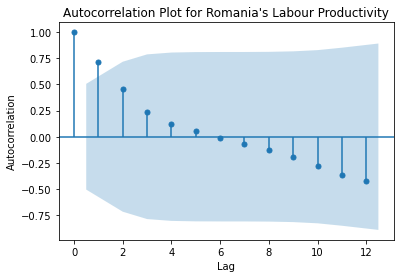

In [85]:
autocorr_plot_country      = 28
autocorr_plot_country_name = labour_csv.iloc[autocorr_plot_country]['Country Name']

x = acorr_ljungbox(labour_csv.iloc[0][2:], lags=[1,2,3,4,5], return_df=False, auto_lag=True)
# print(stats)
# print(x)

# lbvalue: The Ljung-Box test statistic.
# pvalue: The p-value based on chi-square distribution.
# bpvalue: The test statistic for Box-Pierce test.
# bppvalue: The p-value based for Box-Pierce test on chi-square distribution.

fig, ax = plt.subplots()
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plot_acf(labour_csv.iloc[autocorr_plot_country][2:],
         title=f'Autocorrelation Plot for {autocorr_plot_country_name}\'s {autocorr_plot_dataset}',
         ax=ax,
         alpha=0.05)
# fig.show()

# labour_csv.apply(lambda row: stats.stats.diagnostic.acorr_ljungbox(row[2:].astype(float), auto_lag=True)[1][:5], axis='columns')
# z = labour_csv.apply(lambda row: acorr_ljungbox(row[2:].astype(float), lags=range(13), return_df=True)['lb_pvalue'], axis='columns')
# z.insert(0, 'Country Code', labour_csv['Country Code'])
# z


f = lambda s: '{:.4f}'.format(s) if (float(s) <= 0.05) else '{\\textcolor{lightgray}{' + '{:.4f}'.format(s) + '}}'
g = lambda s: s
# print(z.to_latex(index=False, column_format='c|' + 'c' * (len(z.columns)-1), float_format="%.2f", formatters=[g] + [f] * (len(z.columns)-1), escape=False))

within_conf_int = z.iloc[:,1:].apply(lambda col: np.sum(col[col <= 0.05]), axis='rows')
within_conf_int.insert(0, 'Country Code', 0)
within_conf_int
z = z.append(within_conf_int, ignore_index=True)

z